In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool
import pandas_profiling
import eli5
import re

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, precision_recall_curve, plot_precision_recall_curve, average_precision_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD

from urllib.parse import urlparse
from nltk.tokenize import RegexpTokenizer 
from nltk.stem.snowball import SnowballStemmer

/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [11]:
pd.set_option('display.max_colwidth', None)
sns.set_style('darkgrid')
RANDOM_STATE = 42

In [38]:
def split_url(url):
    tokenizer = RegexpTokenizer(r'[A-Za-z]+')
    stemmer = SnowballStemmer(language="english")
    sent = tokenizer.tokenize(url)
    sent = [stemmer.stem(word) for word in sent]
    sent = ' '.join(sent)
    return sent

def vectorize(corpus):
    tfidf = TfidfVectorizer(ngram_range=(1, 3), min_df = 3, 
                            lowercase=True, max_features=150000, 
                            stop_words=['url', 'label', 'stemmed', 'words_count', 'len'])
    url_vec = tfidf.fit_transform(corpus)
    svdT = TruncatedSVD(n_components=150, random_state=RANDOM_STATE)
    url_vec = svdT.fit_transform(url_vec)
    #temp_df = pd.DataFrame(url_vec.toarray(), columns=vectorizer.get_feature_names())
    return url_vec


def get_host_path(address):
    if not re.search(r'^[A-Za-z0-9+.\-]+://', address):
        address = 'tcp://{0}'.format(address)
    return urlparse(address)


def count_num(string):
    if string == None or string == '':
        return 0
    return len(re.sub("[^0-9]", "", string))


def add_features(df):
    df['label'] = df['label'].apply(lambda label: 1 if (label == 'Unsafe') or (label == 'bad') else 0)
    df['stemmed'] = df['url'].apply(split_url)
    df['words_count'] = df['stemmed'].apply(lambda url: len(url.split()))
    #vectorizer = TfidfVectorizer(ngram_range=(1, 1), min_df = 3, lowercase=True, max_features=150000, stop_words=['url', 'label', 'stemmed', 'words_count', 'len'])
    #url_vec = vectorizer.fit_transform(df['stemmed'])
    #temp_df = pd.DataFrame(url_vec.toarray(), columns=vectorizer.get_feature_names())
    df['url_len'] = df['url'].apply(lambda url: len(url))
    
    df['hostname'] = df['url'].apply(lambda url: get_host_path(url).hostname)
    df['path'] = df['url'].apply(lambda url: get_host_path(url).path)
    
    df[['hostname', 'path']].fillna(0, inplace=True)
                                     
    df['hostname_len'] = df['hostname'].apply(lambda item: len(item) if item!=None else 0)
    df['path_len'] = df['path'].apply(lambda item: len(item) if item!=None else 0)
    df['hostname_nums'] = df['hostname'].apply(count_num)
    df['path_nums'] = df['path'].apply(count_num)
                                
    df.drop(['hostname', 'path'], axis=1, inplace=True)
    
    url_vecs = pd.DataFrame(vectorize(df['stemmed']))
    df = pd.concat([df, url_vecs], axis=1)
    return df
    
    
def split(df):
    train_text, temp_text, \
    train_labels, temp_labels = train_test_split(df.drop(['url', 'stemmed'], axis=1),   
                                                 df['label'],
                                                 random_state = RANDOM_STATE,
                                                 test_size = 0.3,
                                                 stratify=df['label'])
    val_text, test_text, \
    val_labels, test_labels = train_test_split(temp_text,
                                              temp_labels,
                                              random_state = RANDOM_STATE,
                                              test_size = 0.5,
                                              stratify=temp_labels)
   
    return train_text.drop(['label'], axis=1), \
           train_labels, \
           val_text.drop(['label'], axis=1), \
           val_labels, \
           test_text.drop(['label'], axis=1), \
           test_labels


def preprocess(df):
    df = add_features(df)
    return split(df)


def train_gbm(train_data, train_labels, val_data, val_labels, test_data, test_labels):
    gbm = CatBoostClassifier(task_type="GPU", logging_level='Silent', 
                             loss_function='Logloss', od_type='Iter', od_wait=20, random_state=RANDOM_STATE)
    eval_pool = Pool(val_data, val_labels)
    gbm.fit(train_data, train_labels, eval_set=eval_pool, use_best_model=True)
    gbm.save_model('catboost_1',
                   format="cbm",
                   export_parameters=None,
                   pool=None)
    pred_labels = gbm.predict(test_data)
    score = [roc_auc_score(pred_labels, test_labels), f1_score(pred_labels, test_labels)]
    
    print('roc_auc: ', score[0])
    print('f1: ', score[1])

    average_precision = average_precision_score(pred_labels, test_labels)

    disp = plot_precision_recall_curve(gbm, test_data, test_labels)
    disp.ax_.set_title('2-class Precision-Recall curve: ')
    
    return gbm

def get_cross_val(model, train_data, train_labels):
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    cv_results = cross_val_score(model, train_data, train_labels, cv=skf, scoring='roc_auc')
    return cv_results

In [39]:
df_small = pd.read_csv('urls.csv')
df_big = pd.read_csv('data.csv')
df = pd.concat([df_small, df_big], axis=0)
df.reset_index(drop=True, inplace=True)

In [40]:
train_data, train_labels, val_data, val_labels, test_data, test_labels = preprocess(df)

/opt/conda/envs/rapids/lib/python3.7/site-packages/pandas/core/frame.py:4320: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [42]:
gbm = CatBoostClassifier(task_type="GPU", logging_level='Silent', 
                         loss_function='Logloss', od_type='Iter')
cv_results = get_cross_val(gbm, train_data, train_labels)
print(cv_results)

[0.98675405 0.98526034 0.98605732 0.98603243 0.98550102]


roc_auc:  0.9619876879456589
f1:  0.9134575909352164


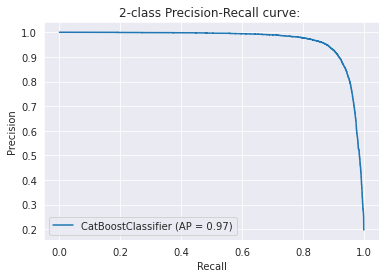

In [43]:
gbm = train_gbm(train_data, train_labels, val_data, val_labels, test_data, test_labels)

In [44]:
eli5.explain_weights_catboost(gbm, vec=None, top=20, importance_type='PredictionValuesChange', feature_names=None, pool=None)

Weight,Feature
0.1228,path_len
0.0497,4
0.0381,39
0.0347,0
0.0329,25
0.0324,1
0.0307,18
0.0307,7
0.0281,21
0.0270,path_nums
